<a href="https://colab.research.google.com/github/AndreyDyachkov/Portfolio/blob/main/1_Data_cleaning_project/Data_cleaning_(YandexPraktikum).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обработка и базовый анализ данных на примере выгрузки для кредитного скоринга

<b>Задача:</b> 
- Очистить данные 
- Оценить влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок.

<b>Описание данных:</b>
- children — количество детей в семье
- days_employed — общий трудовой стаж в днях
- dob_years — возраст клиента в годах
- education — уровень образования клиента
- education_id — идентификатор уровня образования
- family_status — семейное положение
- family_status_id — идентификатор семейного положения
- gender — пол клиента
- income_type — тип занятости
- debt — имел ли задолженность по возврату кредитов (1- задолженность, - нет)
- total_income — ежемесячный доход
- purpose — цель получения кредита

### Этап 1. Импортируем библиотеки, открываем файл и изучаем общую информацию

#### Загружаем библиотеки

In [273]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Загружаем датафрейм из csv файла

In [274]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [275]:

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Y_Praktikum/data/data.csv')
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


Загрузилось без видимых ошибок

#### Получаем общую информацию по датафрейму. Проверяем пропуски, дубли и типы данных.

In [276]:
df.shape

(21525, 12)

In [277]:
df.duplicated().sum()

54

In [278]:
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

In [279]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21471 entries, 0 to 21470
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21471 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21471 non-null  int64  
 3   education         21471 non-null  object 
 4   education_id      21471 non-null  int64  
 5   family_status     21471 non-null  object 
 6   family_status_id  21471 non-null  int64  
 7   gender            21471 non-null  object 
 8   income_type       21471 non-null  object 
 9   debt              21471 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21471 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [280]:
df.isnull().sum().sum()

4240

In [281]:
df.isnull().sum()

children               0
days_employed       2120
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2120
purpose                0
dtype: int64

In [282]:
df.isnull().mean().round(3)

children            0.000
days_employed       0.099
dob_years           0.000
education           0.000
education_id        0.000
family_status       0.000
family_status_id    0.000
gender              0.000
income_type         0.000
debt                0.000
total_income        0.099
purpose             0.000
dtype: float64

<b>Вывод:</b> В датафрейме 12 колонок, 21525 строчек. Выявили 54 полных дубля. По условиям задачи дублей быть не должно - удалили. В двух колонках пропущено 9.9% записей. Типы данных не везде оптимальные - поправим на следующем этапе

#### Посмотрим на датасет: средние значения и стандартные отклонения

In [283]:
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21471.000000,19351.000000,21471.000000,21471.000000,21471.000000,21471.000000,1.935100e+04
mean,0.539565,63046.497661,43.279074,0.817195,0.973685,0.081086,1.674223e+05
std,1.382978,140827.311974,12.574291,0.548508,1.421082,0.272974,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


In [284]:
df[['education','family_status','gender','income_type','purpose']].describe()

,education,family_status,gender,income_type,purpose
count,21471,21471,21471,21471,21471
unique,15,5,3,8,38
top,среднее,женат / замужем,F,сотрудник,свадьба
freq,13705,12344,14189,11091,793


### Вывод по качеству данных (Этап 1). 
По колонкам:
- children (количество детей в семье). Отрицательное минимальное значение и  слишком высокое максимальное значение. Медиана = 0, т.е более чем у половины заемщиков детей нет.
- days_employed (трудовой стаж в днях). Большая часть значений отрицательные (минимум до 75% процентиля) и слишком высокое максимальное значение (401755/365=1100 лет). Тип данных float можно поменять на integer. Около 2000 записей отсутствует.
- dob_years (возраст клиента в годах). Есть нулевые значения. Можно предположить близкое к нормальному распределение, т.к. медиана почти совпадает со средней.
- education (образование клиента), education_id (идентификатор образования). Несовпадает число уникальных значений в education и в education_id (15 vs 5) - необходимо проверить. Колонки дублируют друг  друга - одну можно удалить.
- family_status (семейное положение), family_status_id (идентификатор семейного положения). Всего 5 уникальных значений. Колонки дублируют друг  друга - одну можно удалить.
- gender (пол клиента).  3 уникальных пола - возможно это ошибка.
- income_type (тип занятости). 8 уникальных значений.
- debt (имел ли задолженность по возврату кредитов) - принимает 2 значения, по сути bollean
- total_income (доход в месяц). Около 2000 записей отсутствует. Число записей равно числу записей в days_employed. Возможно пропуски - это безработные или это ошибка. Проверить по income_type. Тип данных float можно поменять на integer
- purpose (цель получения кредита). 38 уникальных целей. Слишком много для анализа. Возможно нужно сделать несколько категорий.

### Этап 2. Предобработка данных

#### Столбец children. Посмотрим на распределение кол-ва детей и исправим ошибки

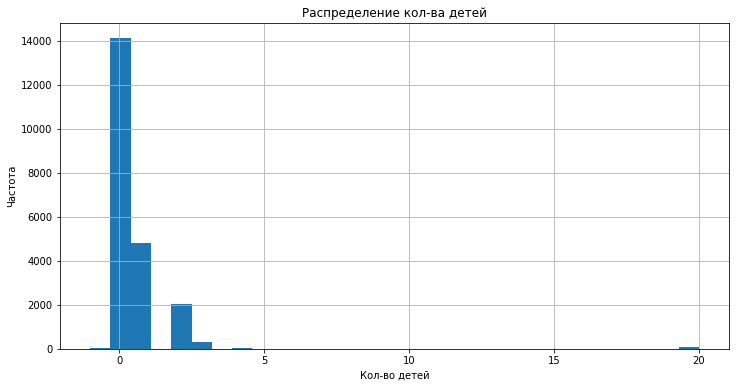

In [285]:
df['children'].hist(bins=30, figsize=(12,6))
plt.title('Распределение кол-ва детей')
plt.xlabel('Кол-во детей')
plt.ylabel('Частота')
plt.show()

In [286]:
df['children'].value_counts()

 0     14107
 1      4809
 2      2052
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

In [287]:
df['children'] = df['children'].replace([-1,20],[1,2])
df['children'].value_counts()

0    14107
1     4856
2     2128
3      330
4       41
5        9
Name: children, dtype: int64

<b>Вывод:</b>  Значения 20 и -1 явно ошибочны. В целом процент ошибок небольшой ((76+47)/21471 = 0.6%) По условиям задачи это опечатки, поэтому меняем на 2 и 1 соответственно.

#### Проверяем dob_years на ошибки:

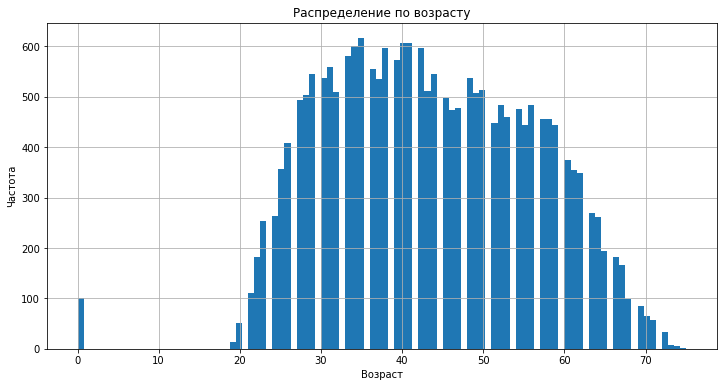

In [288]:
df['dob_years'].hist(bins=100, figsize=(12,6))
plt.title('Распределение по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

In [289]:
df[df['dob_years']==0]['dob_years'].count()

101

<b>Вывод:</b>  Значение 0 явно ошибочно (дети до года кредиты не берут). Доля этих ошибок небольшая (101/21471 = 0.5%) от общего числа записей. Заменяем 0 на среднее с группировкой по income_type, так это позволит подобрать более точный возраст по группам (пенсионеры, студенты и т.п.).

In [290]:
for income_type in df['income_type'].unique():
    mean = round(df[df['income_type']==income_type]['dob_years'].mean(),1)
    print(income_type, mean)
    df.loc[(df['dob_years']==0)&(df['income_type']==income_type),'dob_years'] = mean

сотрудник 39.8
пенсионер 59.1
компаньон 39.7
госслужащий 40.6
безработный 38.0
предприниматель 42.5
студент 22.0
в декрете 39.0


In [291]:
df[df['dob_years']==0]['dob_years'].count()

0

Вариант кода:
    
`df['dob_years'] = df.groupby('income_type')['dob_years'].transform(lambda x: x.replace(0, int(x.median())))`


#### Проверка education и education_id на ошибки

In [292]:
df.groupby(['education_id','education'])['education_id'].count()

education_id  education          
0             ВЫСШЕЕ                   273
              Высшее                   268
              высшее                  4710
1             СРЕДНЕЕ                  772
              Среднее                  711
              среднее                13705
2             НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
              Неоконченное высшее       47
              неоконченное высшее      668
3             НАЧАЛЬНОЕ                 17
              Начальное                 15
              начальное                250
4             УЧЕНАЯ СТЕПЕНЬ             1
              Ученая степень             1
              ученая степень             4
Name: education_id, dtype: int64

In [293]:
df['education'] = df['education'].str.lower()
df.groupby(['education_id','education'])['education_id'].count()

education_id  education          
0             высшее                  5251
1             среднее                15188
2             неоконченное высшее      744
3             начальное                282
4             ученая степень             6
Name: education_id, dtype: int64

In [294]:
df.drop('education_id', axis=1, inplace=True)

<b>Вывод:</b> В education есть неполные дубли. Поэтому привели все к нижнему регистру и дропнули лишнюю колонку education_id. Большая часть заемщиков имеет среднее образование.

#### Проверка  family_status и family_status_id на ошибки

In [295]:
df.groupby(['family_status_id','family_status'])['family_status_id'].count()

family_status_id  family_status        
0                 женат / замужем          12344
1                 гражданский брак          4163
2                 вдовец / вдова             959
3                 в разводе                 1195
4                 Не женат / не замужем     2810
Name: family_status_id, dtype: int64

In [296]:
df['family_status'] = df['family_status'].str.lower()
df.groupby(['family_status_id','family_status'])['family_status_id'].count()

family_status_id  family_status        
0                 женат / замужем          12344
1                 гражданский брак          4163
2                 вдовец / вдова             959
3                 в разводе                 1195
4                 не женат / не замужем     2810
Name: family_status_id, dtype: int64

In [297]:
df.drop('family_status_id', axis=1, inplace=True)

<b>Вывод:</b>  Большая часть заемщиков женаты/замужем. Для красоты привели к нижнему регистру и убрали колонку family_status_id

#### Проверка gender на ошибки.

In [298]:
df['gender'].value_counts()

F      14189
M       7281
XNA        1
Name: gender, dtype: int64

In [299]:
df['gender'] = df['gender'].replace('XNA','F')
df['gender'].value_counts()

F    14190
M     7281
Name: gender, dtype: int64

<b>Вывод:</b>  Пол XNA - ошибка. Заменили на наиболее популярный пол.

#### Проверка income_type на ошибки.

In [300]:
df['income_type'].value_counts()

сотрудник          11091
компаньон           5080
пенсионер           3837
госслужащий         1457
предприниматель        2
безработный            2
студент                1
в декрете              1
Name: income_type, dtype: int64

<b>Вывод:</b>  Все ОК

#### Проверка debt

In [301]:
df['debt'].value_counts()

0    19730
1     1741
Name: debt, dtype: int64

<b>Вывод:</b>  Все ОК

#### Проверка total_income и days_employed

Проверяем вместе так как есть подозрение, что пропуски данных в этих столбцах связаны.Посмотрим на строчки с пропусками в обоих столбцах:

In [302]:
df[(df['total_income'].isnull())&(df['days_employed'].isnull())].head()

,children,days_employed,dob_years,education,family_status,gender,income_type,debt,total_income,purpose
12,0,NaN,65.0,среднее,гражданский брак,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41.0,среднее,женат / замужем,M,госслужащий,0,NaN,образование
29,0,NaN,63.0,среднее,не женат / не замужем,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50.0,среднее,женат / замужем,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54.0,среднее,гражданский брак,F,пенсионер,1,NaN,сыграть свадьбу


Пустые значения total_income и days_employed совпадают. От числа записей всего это: 2174/21471 = 10%. Процент большой - удаление такого кол-ва строчек повляет на результат. total_income - логичнее заполнить медианой по типу занятости. Измеряем медиану в каждом типе и смотрим что получилось.

In [303]:
group_income = df.groupby('income_type')['total_income'].median()
group_income

income_type
безработный        131339.751676
в декрете           53829.130729
госслужащий        150447.935283
компаньон          172357.950966
пенсионер          118514.486412
предприниматель    499163.144947
сотрудник          142594.396847
студент             98201.625314
Name: total_income, dtype: float64

У разных типах занятости действительно разные медианы дохода. Заполняем пропуски этими медианами и проверяем: 

In [304]:
for i in group_income.index:
    df.loc[(df['income_type'] == i) & (df['total_income'].isnull()), 'total_income'] = group_income[i]

df['total_income'].isnull().sum()

0

Вариант кода:
```
med_salary = df.groupby('income_type')['total_income'].transform('median')
df['total_income'] = df['total_income'].fillna(med_salary)
```




Для удобства анализа стажа добавим стаж в годах на основе days_employed и посмотрим на статистику:

In [305]:
df['years_employed'] = df['days_employed'] / 365
df['years_employed'].agg(['mean','median','min','max'])

mean       172.730131
median      -3.296903
min        -50.380685
max       1100.699727
Name: years_employed, dtype: float64

Видим, что большая часть значений отрицательная (медиана ниже 0), ошибочные положительные значения увеличивают среднюю до нереальных цифр. Предполагаем что в некоторых типах занятости стаж указан в часах, которые можно перевести в годы. Проверим разброс значений в каждом income_type:

In [306]:
df.groupby('income_type')['years_employed'].agg(['count','mean','median','min','max'])

,count,mean,median,min,max
income_type,,,,,
безработный,2,1003.873021,1003.873021,924.724567,1083.021476
в декрете,1,-9.032219,-9.032219,-9.032219,-9.032219
госслужащий,1312,-9.314786,-7.368132,-41.624746,-0.109463
компаньон,4577,-5.784998,-4.239403,-48.261817,-0.082727
пенсионер,3443,1000.009565,1000.584401,900.626632,1100.699727
предприниматель,1,-1.426981,-1.426981,-1.426981,-1.426981
сотрудник,10014,-6.373970,-4.312884,-50.380685,-0.066141
студент,1,-1.585621,-1.585621,-1.585621,-1.585621


Безработные и пенсионеры имеют положительные значения которые можно поделить на 24 и получить реалистичные значения в годах.

In [307]:
def hours_to_days(row):
    if row['income_type'] == 'безработный' or row['income_type'] == 'пенсионер':
        return row['years_employed']/24
    else:
        return row['years_employed']

df['years_employed'] = df.apply(hours_to_days,axis=1)

Переводим отрицательные значения в положительные и смотрим что получилось:

In [308]:
df['years_employed'] = df['years_employed'].apply(abs)

df.groupby('income_type')['years_employed'].agg(['count','mean','median','min','max'])

,count,mean,median,min,max
income_type,,,,,
безработный,2,41.828043,41.828043,38.530190,45.125895
в декрете,1,9.032219,9.032219,9.032219,9.032219
госслужащий,1312,9.314786,7.368132,0.109463,41.624746
компаньон,4577,5.784998,4.239403,0.082727,48.261817
пенсионер,3443,41.667065,41.691017,37.526110,45.862489
предприниматель,1,1.426981,1.426981,1.426981,1.426981
сотрудник,10014,6.373970,4.312884,0.066141,50.380685
студент,1,1.585621,1.585621,1.585621,1.585621


Заполняем пропуски по тому же принципу, что и в total income: медианой по каждому income_type. Проверяем 

In [309]:
med_salary = df.groupby('income_type')['years_employed'].transform('median')
df['years_employed'] = df['years_employed'].fillna(med_salary)

df['years_employed'].isnull().sum()

0

Пропусков данных в years_employed нет. Т.к. у нас стаж в годах, столбец days_employed не нужен - удаляем и проверяем: 

In [310]:
df = df.drop('days_employed', 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21471 entries, 0 to 21470
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   children        21471 non-null  int64  
 1   dob_years       21471 non-null  float64
 2   education       21471 non-null  object 
 3   family_status   21471 non-null  object 
 4   gender          21471 non-null  object 
 5   income_type     21471 non-null  object 
 6   debt            21471 non-null  int64  
 7   total_income    21471 non-null  float64
 8   purpose         21471 non-null  object 
 9   years_employed  21471 non-null  float64
dtypes: float64(3), int64(2), object(5)
memory usage: 1.6+ MB


#### Проверка purpose

In [311]:
df['purpose'].value_counts()

свадьба                                   793
на проведение свадьбы                     773
сыграть свадьбу                           769
операции с недвижимостью                  675
покупка коммерческой недвижимости         662
операции с жильем                         652
покупка жилья для сдачи                   652
операции с коммерческой недвижимостью     650
жилье                                     646
покупка жилья                             646
покупка жилья для семьи                   638
строительство собственной недвижимости    635
недвижимость                              633
операции со своей недвижимостью           627
строительство жилой недвижимости          625
покупка недвижимости                      621
покупка своего жилья                      620
строительство недвижимости                619
ремонт жилью                              607
покупка жилой недвижимости                606
на покупку своего автомобиля              505
заняться высшим образованием      

В purpose есть неполные дубли.

### Вывод по пропускам и ошибкам
С пропусками и ошибками сделали следующее:
> - children (количество детей в семье) - выявили ошибки в кол-ве детей: -1 и 20, исправили на 1 и 20 соответственно, предполагая что это опечатки.
> - days_employed (трудовой стаж в днях) - Выяснили что у пенсионеров и безработных положительные значения, у всех остальных отрицательные. При этом стаж у пенсионеров и безработных указан в часах. Привели все к единому формату в годах, колонка years_employed): пенсионеров и безработных поделили на 24; все значения поделили на 365 и сделали положительными). Пропуски заменили медианой в разбивке по income_type. days_employed удалили.
> - dob_years (возраст клиента в годах). Значения равные 0 заменили на среднее по группе income_type. 
> - education (образование клиента), education_id (идентификатор образования) - заменили текст в разных регистрах на нижний регистр и сократили число уникальных значений до 5, education_id удалили.
> - family_status (семейное положение), family_status_id (идентификатор семейного положения) - перевели в нижний регистр, family_status_id удалили
> - gender (пол клиента) - выявили одну ошибку и заменили на F(более популярный пол).
> - income_type (тип занятости) - без изменений
> - debt  - без изменений
> - total_income (доход в месяц) - пропуски заменили на медиану по каждому income_type.
> - purpose (цель получения кредита) - можно сгруппировать в несколько категорий.

#### Замена типа данных

Меняем float на int и проверяем.

In [312]:
col_list = ['dob_years','total_income','years_employed']

for col in col_list:

    df[col] = df[col].astype('int')
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21471 entries, 0 to 21470
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   children        21471 non-null  int64 
 1   dob_years       21471 non-null  int64 
 2   education       21471 non-null  object
 3   family_status   21471 non-null  object
 4   gender          21471 non-null  object
 5   income_type     21471 non-null  object
 6   debt            21471 non-null  int64 
 7   total_income    21471 non-null  int64 
 8   purpose         21471 non-null  object
 9   years_employed  21471 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 1.6+ MB


<b>Вывод: </b> float поменяли на integer. Остальное оставили как есть.

#### Обработка дубликатов

Проверяем датафрейм на дубликаты:

In [313]:
df.duplicated().sum()

17

<b>Вывод: </b> Нашли 17 одинаковых строк, которые возникли после заполнения пропусков и исправления ошибок. По условиям задачи сроки удаляем.

In [314]:
df = df.drop_duplicates().reset_index(drop=True)

#### Категоризация данных

Возвращаемся к purpose:

In [315]:
df['purpose'].value_counts()

свадьба                                   791
на проведение свадьбы                     768
сыграть свадьбу                           765
операции с недвижимостью                  675
покупка коммерческой недвижимости         661
операции с жильем                         652
покупка жилья для сдачи                   651
операции с коммерческой недвижимостью     650
жилье                                     646
покупка жилья                             646
покупка жилья для семьи                   638
строительство собственной недвижимости    635
недвижимость                              633
операции со своей недвижимостью           627
строительство жилой недвижимости          624
покупка недвижимости                      621
покупка своего жилья                      620
строительство недвижимости                619
ремонт жилью                              607
покупка жилой недвижимости                606
на покупку своего автомобиля              505
заняться высшим образованием      

Выделяем: авто, недвижимость, образование, свадьба. Проставляем категории в отдельную колонку и смотрим что получилось.

In [316]:
def purpose_cat(row):
    if 'авто' in row:
      return 'vehicle'
    elif 'недвиж' in row or 'жиль' in row:
      return 'real estate'
    elif 'свадьб' in row:
      return 'marriage'
    elif 'образов' in row:
      return 'education'
        
df['purpose_cat'] = df['purpose'].apply(purpose_cat)

In [317]:
df['purpose_cat'].value_counts(dropna=False)

real estate    10811
vehicle         4306
education       4013
marriage        2324
Name: purpose_cat, dtype: int64

Категоризируем dob_years и проверяем чтобы разбивка была более менее равномерна по кол-ву записей. Также интересно сразу посмотреть влияние на debt.

In [318]:
df['dob_years_cat'] = pd.qcut(df['dob_years'],5)
df.groupby('dob_years_cat')['debt'].agg(['count','mean'])

,count,mean
dob_years_cat,,
"(18.999, 32.0]",4785,0.110972
"(32.0, 39.0]",4132,0.091239
"(39.0, 47.0]",4316,0.078545
"(47.0, 56.0]",4348,0.065777
"(56.0, 75.0]",3873,0.053705


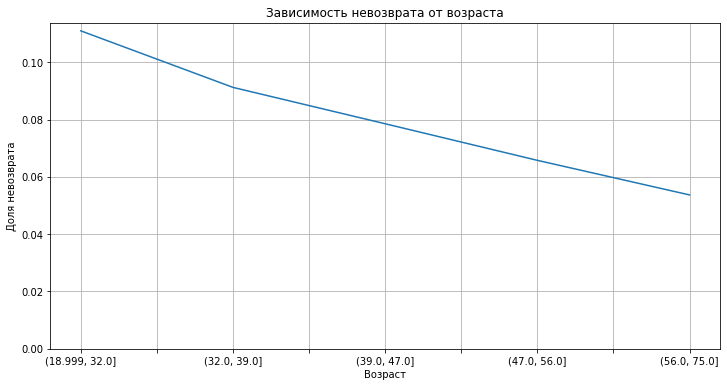

In [319]:
df.groupby('dob_years_cat')['debt'].mean().plot(grid=True,ylim=0, figsize=(12,6))
plt.title('Зависимость невозврата от возраста')
plt.xlabel('Возраст')
plt.ylabel('Доля невозврата')
plt.show()

Зависимость возврата кредита от возраста вероятно есть - чем меньше возраст тем чаще невозврат.

Категоризируем total_income.

In [320]:
df['total_income_cat'] = pd.cut(df['total_income'],[20000,80000,120000,160000,200000, 400000, np.inf])

In [321]:
df.groupby('total_income_cat')['debt'].agg(['count','mean'])

,count,mean
total_income_cat,,
"(20000.0, 80000.0]",2276,0.076450
"(80000.0, 120000.0]",4955,0.083148
"(120000.0, 160000.0]",5503,0.088497
"(160000.0, 200000.0]",3653,0.084862
"(200000.0, 400000.0]",4538,0.072058
"(400000.0, inf]",529,0.058601


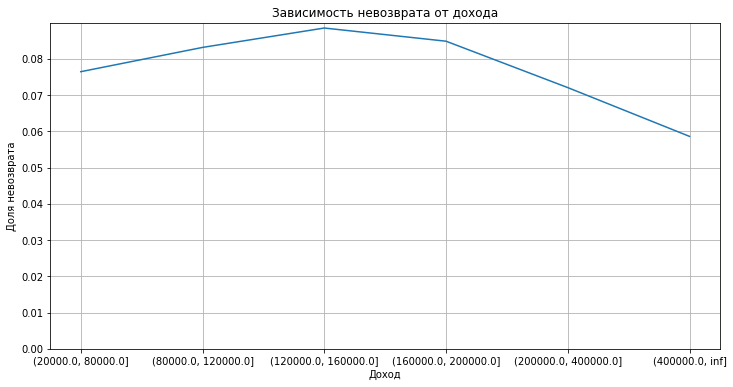

In [322]:
df.groupby('total_income_cat')['debt'].mean().plot(grid=True,ylim=0, figsize=(12,6))
plt.title('Зависимость невозврата от дохода')
plt.xlabel('Доход')
plt.ylabel('Доля невозврата')
plt.show()

Заемщики с доходом от 120 до 200 являются наиболее рисковыми клиентами.  Остальные группы имеют более низкий невозврат. Видимо есть нелинейная зависимость

Категоризируем years_employed

In [323]:
def years_employed_cat(years_employed):
    if years_employed == 1:
        return '1_1'
    if years_employed >= 2 and years_employed <=3:
        return '2_2-3'
    if years_employed >= 4 and years_employed <=5:
        return '3_4-5'
    if years_employed >= 6 and years_employed <=10:
        return '4_6-10'
    if years_employed >= 10 and years_employed <=50:
        return '5_10-50'
    return '0'

df['years_employed_cat'] = df['years_employed'].apply(years_employed_cat)

In [324]:
df.groupby('years_employed_cat')['debt'].agg(['count','mean'])

,count,mean
years_employed_cat,,
0,1827,0.105638
1_1,2024,0.117589
2_2-3,3438,0.100349
3_4-5,3945,0.080862
4_6-10,3695,0.078484
5_10-50,6525,0.054559


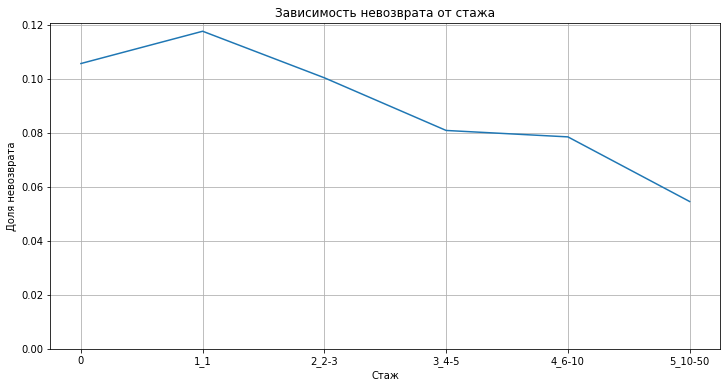

In [325]:
df.groupby('years_employed_cat')['debt'].mean().plot(grid=True,ylim=0, figsize=(12,6))
plt.title('Зависимость невозврата от стажа')
plt.xlabel('Стаж')
plt.ylabel('Доля невозврата')
plt.show()

Наибольший риск невозврата при стаже 1 год, с ростом стажа вероятность снижается.

### Вывод по категоризации данных
Разбили total_income, years_employed и dob_years на категории. Предположительно есть зависимость между этими тремя переменными и вероятностью возврата кредита.

### Этап 3. Ответы на вопросы

#### Есть ли зависимость между наличием детей и возвратом кредита в срок?

Оценим среднее число детей для обоих значений debt.

In [326]:
df.groupby('debt')['children'].mean().round(3)

debt
0    0.475
1    0.543
Name: children, dtype: float64

У заемщиков с невозвратами в среднем больше детей. 
Посмотрим наоборот среднее по debt в разбивке по кол-ву детей

In [327]:
df.groupby('children')['debt'].mean().round(3)

children
0    0.075
1    0.092
2    0.095
3    0.082
4    0.098
5    0.000
Name: debt, dtype: float64

In [328]:
df['children'].value_counts()

0    14091
1     4855
2     2128
3      330
4       41
5        9
Name: children, dtype: int64

<b>Вывод:</b>
Наличие детей повышает риск невозврата (между 0 и 1 ребенком происходит рост невозвратов, с 7 до 9 %). У заемщиков с детьми % варьируется незначительно. Выделяется группа семей с тремя детьми, она наиболее безопасная (если не учитывать семьи без детей).

#### Есть ли зависимость между семейным положением и возвратом кредита в срок?

Смотрим среднюю по debt в разбивке по семейному статусу и кол-во записей с каждым статусом

In [329]:
df.groupby('family_status')['debt'].mean()

family_status
в разводе                0.071130
вдовец / вдова           0.065693
гражданский брак         0.093471
женат / замужем          0.075452
не женат / не замужем    0.097509
Name: debt, dtype: float64

In [330]:
df['family_status'].value_counts()

женат / замужем          12339
гражданский брак          4151
не женат / не замужем     2810
в разводе                 1195
вдовец / вдова             959
Name: family_status, dtype: int64

<b>Вывод:</b>
Люди, которые не состоят в официальных отношениях и никогда не состояли хуже возвращают кредиты, в отличии от семей, которые имеют официальный статус, пусть даже когда-то в прошлом. Возможно что тут есть еще определенное влияние возраста, так как люди состоящие в официальных отношениях \ разводе \ вдовстве как правило старше.

Проверяем зависимость семейного статуса от возраста и вероятность невозврата в разбивке по возрастным группам:

In [331]:
df.groupby('family_status')['dob_years'].agg(['mean','median'])

,mean,median
family_status,,
в разводе,45.879498,46
вдовец / вдова,56.811262,58
гражданский брак,42.271983,41
женат / замужем,43.715131,43
не женат / не замужем,38.614235,36


In [332]:
df.groupby('dob_years_cat')['debt'].agg(['mean','median'])

,mean,median
dob_years_cat,,
"(18.999, 32.0]",0.110972,0
"(32.0, 39.0]",0.091239,0
"(39.0, 47.0]",0.078545,0
"(47.0, 56.0]",0.065777,0
"(56.0, 75.0]",0.053705,0


Да, люди состоящие в официальных отношениях \ разводе \ вдовстве в среднем старше. И с возрастом вероятность невозврата кредита уменьшается.

#### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Смотрим средний доход и медиану у тех кто вернул и не вернул. А также среднюю по debt в разбивке по категориям дохода:

In [333]:
df.groupby('debt')['total_income'].agg(['mean','median'])

,mean,median
debt,,
0,165687.076599,142594
1,161158.393452,142594


In [334]:
df.groupby('total_income_cat').agg({'debt': 'mean'})

,debt
total_income_cat,
"(20000.0, 80000.0]",0.076450
"(80000.0, 120000.0]",0.083148
"(120000.0, 160000.0]",0.088497
"(160000.0, 200000.0]",0.084862
"(200000.0, 400000.0]",0.072058
"(400000.0, inf]",0.058601


<b>Вывод:</b>
Зависимость вероятности невозврата кредита от уровня дохода есть, наибольший % невозврата у заемщиков со средним доходом и с доходом выше среднего (при разбивке по квантилям)  или в диапазоне 120-160 тыс. руб. Наименьший риск невозврата у заемщиков с высоким доходом.

#### Как разные цели кредита влияют на его возврат в срок?

Смотрим среднюю по debt в разбивке по категориям целей кредита

In [335]:
df.groupby('purpose_cat')['debt'].mean()

purpose_cat
education      0.092200
marriage       0.080034
real estate    0.072334
vehicle        0.093590
Name: debt, dtype: float64

<b>Вывод:</b>
Невозврат по кредиту больше при займах на автомобиль и образование. Тогда как по кредитам на недвижимость и свадьбу невозвратов меньше.

### Этап 4. Общий вывод

На основании анализа данных по заемщикам можно предположить зависимость между числом детей и риском невозврата кредита - при наличии детей риск возрастает. 

Также на вероятность невозврата кредита вероятно влияет семейное положение: наибольший риск невозврата у неженатых/незамужних заемщиков и заемщиков, состоящих в гражданском браке; наименьший риск невозврата у заемщиков в статусе: вдовец / вдова. Возможно это обусловлено возрастом: надежность заемщика с возрастом растет, при этом люди несостоящие в браке или состоявшие в гражданском браке в среднем моложе, а заемщики состоящие или состоявшие в браке - старше. 

Уровень дохода связан с вероятность возврата кредита: наименее надежны заемщики со средним доходом и доходом выше среднего, при оценке по квартилям, или с доходом в диапазоне 120-160 тыс. руб. Наиболее надежны заемщики с высоким уровнем дохода.

Цели кредита влияют на риск невозврата: кредиты на свадьбу и недвижимость возвращают в срок чаще, в том время как кредиты на образование и автомобиль являются более рискованными для кредитной организации.